In [98]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Flatten
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import scipy.ndimage as ndimage

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [99]:
tf.__version__

'2.1.0'

In [100]:
print("Number of GPU available: ",len(tf.config.experimental.list_physical_devices("GPU")))

Number of GPU available:  2


In [101]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

In [102]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.reshape(tf.where(parts[-2] == CLASS_NAMES),[])

In [103]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [104]:
# @tf.function
# def rotate_tf(image):
#     if image.shape.__len__() ==4:
#             
#         random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -np
#         .pi / 4, maxval = np.pi / 4)
#     if image.shape.__len__() ==3:
#         random_angles = tf.random.uniform(shape = (), minval = -np
#         .pi / 4, maxval = np.pi / 4)
# 
#     return tfa.image.rotate(image,random_angles)

# below functions rotate image using py_function
# def random_rotate_image(image):
#   image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
#   return image
#
# def tf_random_rotate_image(image, label):
#   im_shape = image.shape
#   [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#   image.set_shape(im_shape)
#   return image, label
#
# rot_ds = train_ds.map(tf_random_rotate_image)

In [105]:
def augment(image):
  # image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  # image = tf.image.resize_with_crop_or_pad(image, IMG_WIDTH+6, IMG_HEIGHT+6) # Add 6 pixels of padding
  # image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
  # image = tf.image.random_contrast(image, lower, upper, seed=None)
  image = tf.image.random_flip_left_right(image,seed=5)
  image = tf.image.random_flip_up_down(image, seed=5)
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  # image = tf.image.random_jpeg_quality(image, min_jpeg_quality, max_jpeg_quality, seed=5)
  # image = tf.image.random_saturation(image, lower, upper, seed=5)
  return image


In [106]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = augment(img)
  return img, label


In [107]:
data_dir=r'C:\Users\kuki\Desktop\Skin\TensorData\train'
data_dir = pathlib.Path(data_dir)
train_image_count = len(list(data_dir.glob('*\*.jpg')))
train_image_count

2749

In [108]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
CLASS_NAMES

array(['old', 'young'], dtype='<U5')

In [109]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [110]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\kuki\\Desktop\\Skin\\TensorData\\train\\old\\2227_sec068_old.jpg'
b'C:\\Users\\kuki\\Desktop\\Skin\\TensorData\\train\\old\\783_sec068_old.jpg'
b'C:\\Users\\kuki\\Desktop\\Skin\\TensorData\\train\\old\\721_sec068_old.jpg'
b'C:\\Users\\kuki\\Desktop\\Skin\\TensorData\\train\\old\\1048_sec068_old.jpg'
b'C:\\Users\\kuki\\Desktop\\Skin\\TensorData\\train\\old\\2308_sec068_old.jpg'


In [111]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 256
epochs = 10

In [112]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [113]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", CLASS_NAMES[label.numpy()])

Image shape:  (100, 100, 3)
Label:  young


In [114]:
shuffle_buffer_size = 100 # affect randomness of dataset. it will take first 1000 from dataset and shuffle and pick one.

train_ds = (labeled_ds
            .cache("./fibro_train.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )
image_batch, label_batch = next(iter(train_ds))

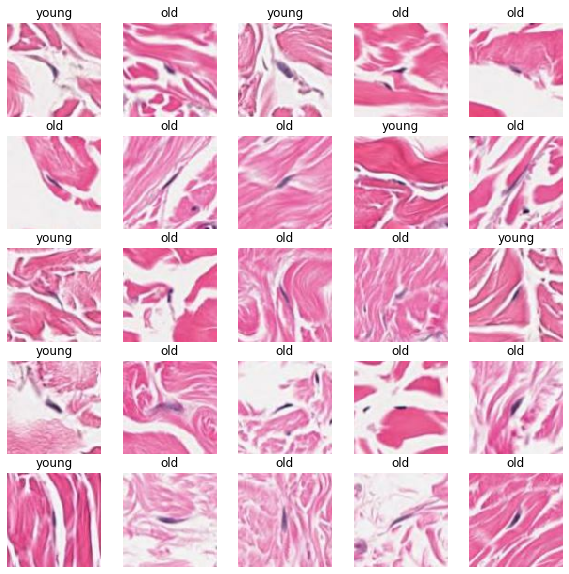

In [115]:
show_batch(image_batch.numpy(), label_batch.numpy())

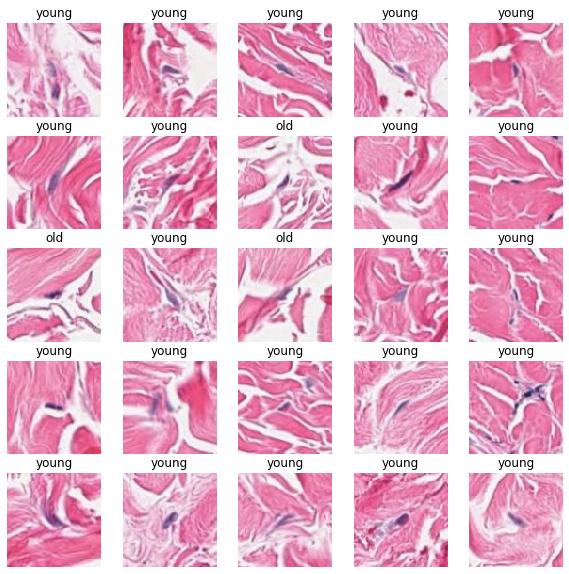

In [116]:
test_data_dir=r'C:\Users\kuki\Desktop\Skin\TensorData\test'
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*\*.jpg')))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = (test_labeled_ds
            .cache("./fibro_test.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )
test_image_batch, test_label_batch = next(iter(test_ds))
show_batch(test_image_batch.numpy(), test_label_batch.numpy())

In [117]:
# val_ds = (
#     test_ds
#     .map(convert, num_parallel_calls=AUTOTUNE)
#     .batch(2*BATCH_SIZE)
# )
# val_image_count =

In [118]:
model_aug = tf.keras.Sequential([
  Flatten(input_shape=(100,100,3)),
  Dense(128, activation='relu'),
  Dense(2)
])

In [119]:
model_yesterday= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])

In [120]:
model_cnn = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [121]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [122]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  #for multiple choice question

In [135]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=None, cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():
    model = tf.keras.Sequential([
    Flatten(input_shape=(100,100,3)),
    Dense(128, activation='relu'),
    Dense(2)
    ])
    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [124]:
model = model_aug
model.compile(optimizer='adam',
          loss=loss_fn,
          metrics=['accuracy'])

In [136]:
history = model.fit(train_ds,
      steps_per_epoch=train_image_count // BATCH_SIZE,
      epochs=epochs,
      verbose=2,
      validation_data=test_ds,
      validation_steps=test_image_count // BATCH_SIZE)

Train for 10 steps, validate for 1 steps
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
10/10 - 4s - loss: 16.8581 - accuracy: 0.6734 - val_loss: 24.2021 - val_accuracy: 0.1914
Epoch 2/10
10/10 - 1s - loss: 4.0096 - accuracy: 0.7918 - val_loss: 1.5828 - val_accuracy: 0.1914
Epoch 3/10
10/10 - 1s - loss: 0.6711 - accuracy: 0.3172 - val_loss: 0.6912 - val_accuracy: 0.8086
Epoch 4/10
10/10 - 1s - loss: 0.6935 - accuracy: 0.4363 - val_loss: 0.6949 - val_accuracy: 0.1914
Epoch 5/10
10/10 - 1s - loss: 0.6894 - accuracy: 0.7918 - val_loss: 0.7002 - val_accuracy: 0.1914
Epoch 6/10
10/10 - 1s - loss: 0.6843 - accuracy: 0.7910 - val_loss: 0.7060 - val_accuracy: 0.1914
Epoch 7/10
10/10 - 1s - loss: 0.6789 - ac

In [126]:
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #for A or B question

model2 = model_yesterday
model2.summary()
model2.compile(optimizer='adam',
          loss=loss_fn,
          metrics=['accuracy'])

history2 = model2.fit(train_ds, 
          steps_per_epoch=train_image_count // BATCH_SIZE,
          epochs=epochs,
          verbose=2,
          validation_data=test_ds,
          validation_steps=test_image_count // BATCH_SIZE)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten_13 (Flatten)         (None, 28224)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

(0, 1)

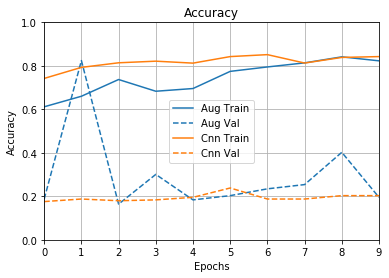

In [127]:
run1 = "aug"
run2 = "cnn"

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({run1: history, run2: history2}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0,1])

(0, 1)

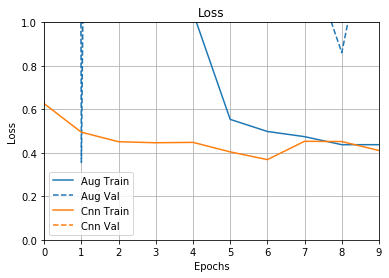

In [128]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({run1: history, run2: history2}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

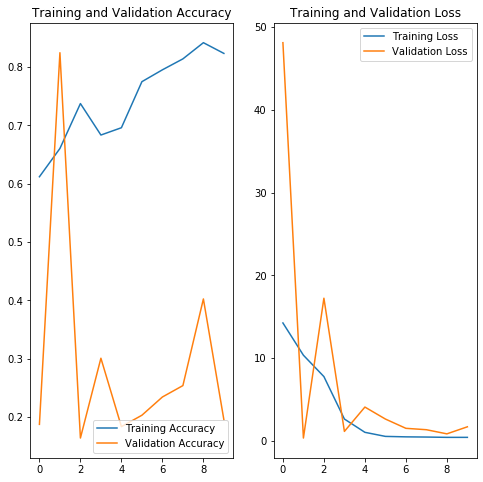

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

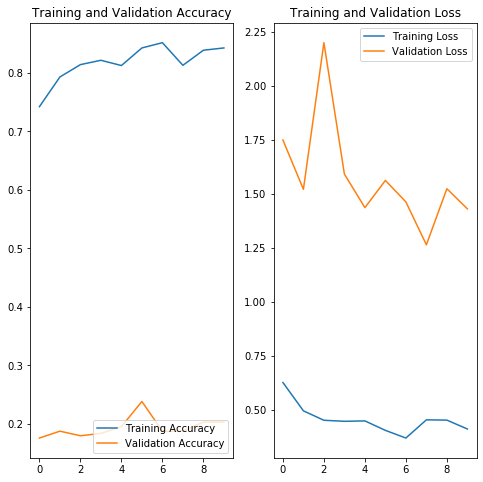

In [130]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [131]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(image_batch)